# [E11] 폐렴 진단기 성능개선
### 목차
1. Set Up
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화
8. 회고
--- 
### 루브릭 평가 기준
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
    * 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
    * regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
    * Accuracy 기준 85%에 도달하였다.

## 1. Set Up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


* 이번 예제에서 사용할 라이브러리 import
* BATCH_SIZE를 비롯한, 예제에서 사용할 변수 선언

## 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* train, test, validation data 가져오기
* train은 총 5216개, test는 624개, validation은 16개
* train set에 비해, validation set의 갯수가 너무 적기 때문에, 두 data를 합친 후 80:20으로 재 분할

In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


* train data와 validation data를 모두 하나의 filenames라는 변수에 저장
* 이후, 모아진 filenames를 8:2로 분할
* 최종적으로 만들어진 train data의 갯수는 4185개이며, validation data는 1047개

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0614-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


* train data 안에 있는 정상 이미지와 폐렴 이미지를 파일 이름으로 구분

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


* 정상 이미지의 갯수는 1070개
* 폐렴 이미지의 갯수는 3115개
* 정상 이미지에 비해서 폐렴 이미지의 갯수가 3배 더 많기 때문에, 추후에 데이터 불균형 문제를 해결할 예정 (CNN에서는 데이터 클래스의 균형이 맞을수록 훈련을 잘함)

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

* tf.data 인스턴스 생성
* tf.data는 학습 과정에서, 배치처리 작업을 보다 효율적으로 할 수 있음

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* train data set과 validation data set의 갯수를 확인
* train set의 갯수는 4185개
* validation set의 갯수는 1047개

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 주어진 데이터에는 라벨이 없음
* 따라서, 데이터 파일 경로에 포함된 단어를 이용하여 라벨을 생성

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* decode_img(): 이미지를 알맞은 형식으로 바꿈
* process_path(): 이미지 파일의 경로를 입력으로 받으며, 이미지와 라벨을 읽어옴

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

* 지금까지 만든 이미지와 라벨을 이용하여 최종적인 train set과 validation set을 선언

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


* 이미지 리사이즈와 라벨 추가가 정상적으로 작동하였는지 확인

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* test set도 위에서 train, validation set을 만든 것과 동일하게 선언

In [14]:
# 기존 노드 내용

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
# # 좌우 반전 augmentation 도입

# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

* prepare_for_training(): 학습 데이터를 효율적으로 사용할 수 있도록 데이터를 변환시켜주는 함수
* 아래의 '좌우 반전 augmentation 도입' 부분은, 이미지를 랜덤하게 좌우 반전하는 함수를 추가한 코드로, 모델 성능 향상에 도움을 줄 수도 있음
* 실제로 좌우 반전 augmentation을 사용한 결과, 사용하지 않은 모델보다 성능이 저하됨을 확인
* **의료 데이터의 경우, 원본 이미지를 회전시키거나 노이즈를 추가하는 작업은 위험할 수 있으며, 성능 향상을 위한 적합한 방법이 아님**

## 3. 데이터 시각화

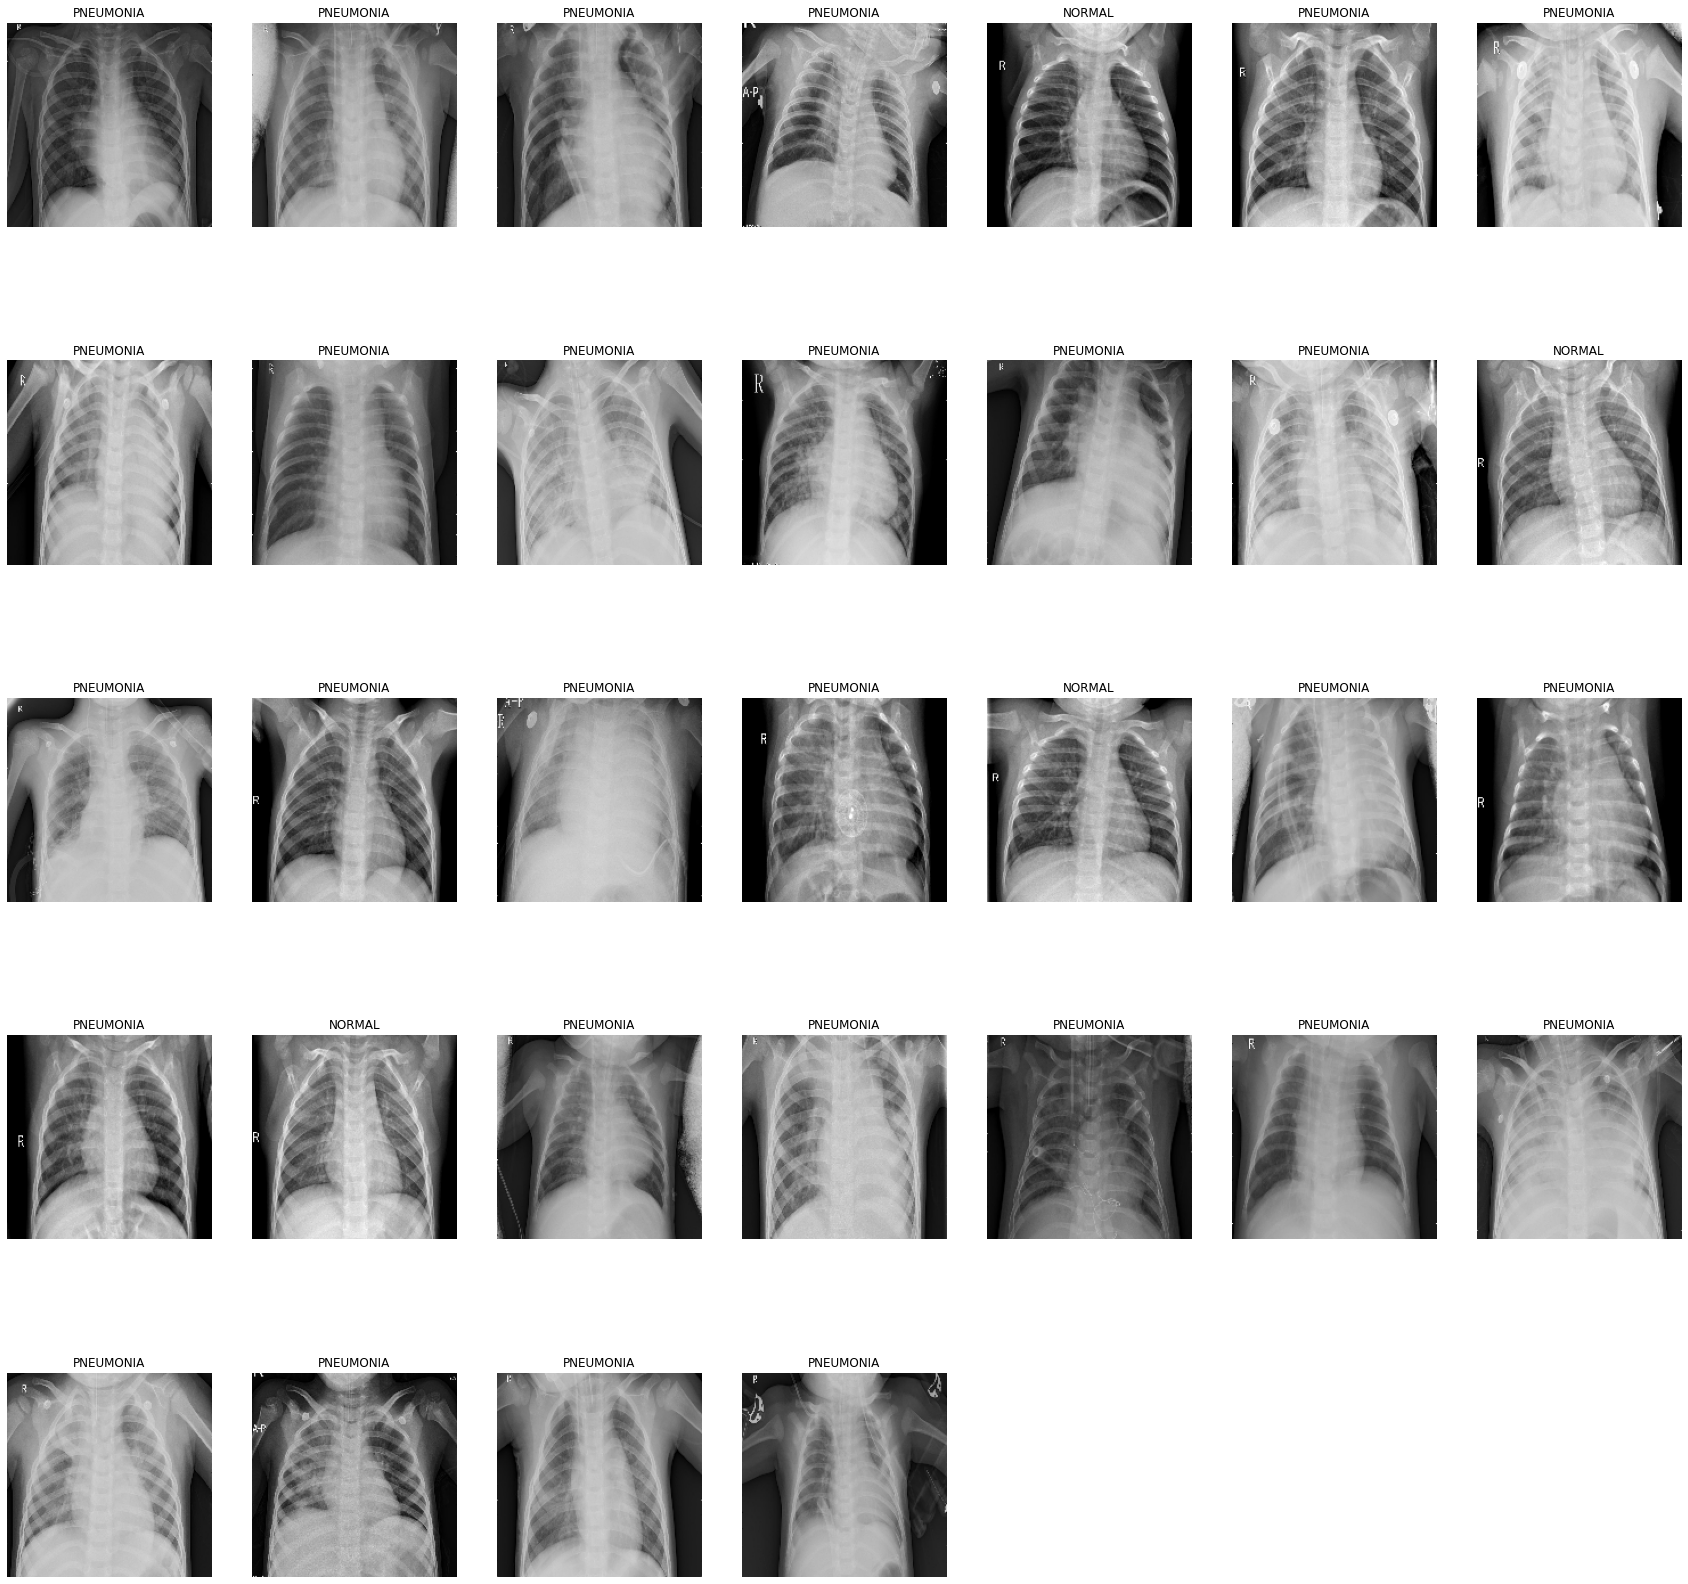

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

* train set에 있는 batch 중 첫 번째 batch를 출력
* X-RAY 사진 상, 폐 부분에 음영이 관찰되는 경우, 폐렴 환자의 이미지로 판단

## 4. CNN 모델링

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

* Convolution block
* 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
* 마지막으로 MaxPooling을 진행

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* Dense Block
* Batch Normalization과 Dropout을 진행
* Batch Normalization과 Dropout을 함께 진행하는 것은 일반적으로 사용되는 형태는 아님
* Dropout을 제거한 후 학습시켰을 때, model의 성능이 가장 크게 향상되는 것을 확인

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* Conv2D layer와 MaxPool2D layer를 이용하여 model을 설계
* dropout layer를 제거한 후 훈련시켰을 때, model의 성능이 크게 향상되었음

## 5. 데이터 imbalance 처리 

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


* 정상 데이터와 폐렴 데이터의 불균형 문제가 있음
* 불균형 데이터로 학습 할 경우, 효과가 좋지 못함
* 불균형 문제를 해결하기 위해, Weight balancing 테크닉을 사용
* training set에서 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
* weight는 정상과 폐렴 전체 데이터 수에 반비례하도록 설정

## 6. 모델 훈련

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

* GPU를 사용하여 훈련
* 데이터의 라벨이 '정상'과 '폐렴', 두 가지이기 때문에 binary_cross entropy를 사용
* optimizer는 adam을 사용

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 56s 271ms/step - loss: 0.2911 - accuracy: 0.8538 - precision: 0.9708 - recall: 0.8289 - val_loss: 0.6048 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 33s 256ms/step - loss: 0.1701 - accuracy: 0.9405 - precision: 0.9774 - recall: 0.9418 - val_loss: 0.9005 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 33s 257ms/step - loss: 0.1298 - accuracy: 0.9581 - precision: 0.9802 - recall: 0.9619 - val_loss: 0.9246 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 33s 257ms/step - loss: 0.0981 - accuracy: 0.9675 - precision: 0.9913 - recall: 0.9644 - val_loss: 1.1824 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 34s 259ms/step - loss: 0.0596 - accura

* model을 학습

## 7. 결과 확인과 시각화

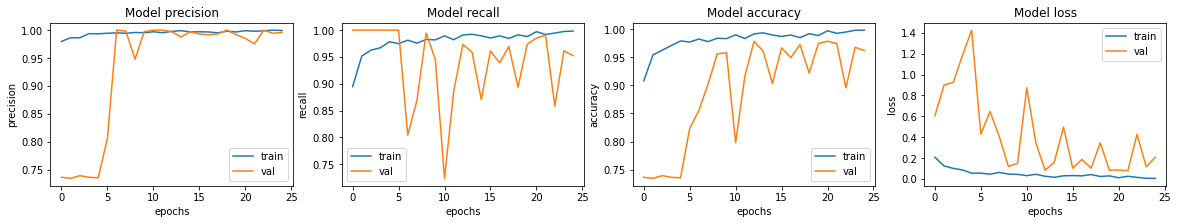

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* model의 학습 결과를 시각화
* 각 epochs 마다 precision, recall, accuracy, loss의 변화 확인 가능
---
   
   
* precision의 경우, train과 validation이 거의 일치하는 경향을 보여줌. 이를 통해 model이 정답이라고 예측한 케이스 중에 실제 정답이 많았다는 것을 의미함
  
  
* recall의 경우, 해당 예제와 같은 의료 분야에서는 굉장히 중요. recall은 실제 정답 중에서 model이 정답이라고 예측한 케이스의 비율로, 의료 분야의 경우 실제 환자를 환자라고 예측한 경우에 해당함. 의료 분야는 정상인을 정상이라고 예측하는 것도 중요하지만, 그 보다 환자를 환자라고 예측하는 것이 더 중요하기 때문에 recall 값이 중요하며, 현재 model의 recall 값은 약 0.97로 굉장히 정확한 예측을 한다고 판단
  
  
* accuracy의 경우, train과 validation의 격차가 줄어들지만, validation 그래프가 큰 폭으로 요동치는 것을 확인할 수 있음. 일부 epochs에 대해서 accuracy가 급격하게 감소하는 이유는 모르겠지만, 좋은 model 혹은 좋은 학습을 했다고 얘기할 수는 없다고 판단
  
  
* loss의 경우, epochs의 수가 늘어날 수록, loss가 줄어드는 경향을 보이지만, accuracy와 마찬가지로 validation 그래프가 큰 폭으로 요동치는 경향을 확인할 수 있음.

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 10s 495ms/step - loss: 0.8633 - accuracy: 0.8638 - precision: 0.8381 - recall: 0.9692
Loss: 0.8632706999778748,
Accuracy: 0.8637820482254028,
Precision: 0.8381374478340149,
Recall: 0.9692307710647583


* test set을 이용하여 model 평가 후, loss, accuracy, precision, recall 값을 출력

## 8. 회고

* 기존 노드: loss: 0.9696, accuracy: 0.7965, precision: 0.7553, recall: 0.9974
* 좌우 반전 augmentation 도입: loss: 0.5908, accuracy: 0.8205, precision: 0.7920, recall: 0.9667
* BATCH_SIZE=16, dropout 제거: loss: 1.3503, accuracy: 0.8349, precision: 0.7947, recall: 0.9923
* BATCH_SIZE=16, dropout 제거, 좌우 반전: loss: 0.8273, accuracy: 0.8269, precision: 0.7987, recall: 0.9667
* BATCH_SIZE=32: loss: 1.0370, accuracy: 0.7612, precision: 0.7269, recall: 0.9897
* BATCH_SIZE=32, dropout 제거: loss: 0.8633, accuracy: 0.8638, precision: 0.8381, recall: 0.9692
  
---
  
* BATCH_SIZE를 32로 증가시켰을 때, accuracy가 증가하는 경향을 보였다. 그러나, BATCH_SIZE가 64 이상으로 증가하는 경우에는 accuracy가 감소하는 경향을 보였는데, 이는 전체 데이터 수에 비해서 BATCH_SIZE가 크기때문에 발생하는 문제가 아닐까 생각된다. 또한 좌우 반전 augmentation을 도입하는 경우, accuracy가 증가하는 경향을 보였지만, 좌우 반전 augmentation을 사용하지 않고 accuracy를 85% 이상으로 만드는 것이 목표였다. 이유는, 의료 데이터의 경우, 데이터의 회전이나 반전, 노이즈 추가와 같은 손상을 주지 않고 원본 데이터 그대로를 사용하는 것이 중요하기 때문이다. 데이터에 손상을 주게 되면 model의 예측에 대한 신뢰성이 떨어지기 때문이라고 생각된다. 다음으로 regularization 과정에서 batch normalization과 dropout을 함께 사용하지 않고, dropout을 제거해봤다. 그 결과, model의 accuracy가 상승하였고, 최종적으로 BATCH_SIZE=32, dropout 제거한 model에서 약 86%의 정확도가 측정되었다.
   
---
   
* 확실히 NLP 노드에 비해서 직관적이었다. 내가 설계한 model에서 어느 부분이 잘못되었는지, 어떻게 해야 성능을 향상시킬 수 있는지에 대해서 조금 더 명확한 느낌이 들었다. 다만, 노드 내용에서 데이터를 좌우 반전시키는 내용에 대해서는 조금 의아했다. 물론, 좌우 반전시키는 것이 데이터에 큰 손상을 입히는 것은 아니다. 그러나, 이 내용을 보고 처음 배우는 사람들은 의료 데이터에 손상을 입히는 것이 얼마나 큰 문제인지 모를 가능성이 높다. 그런 사람들을 대상으로 의료 데이터를 손상시키는 작업을 진행한다는 것은 조금은 위험한 가르침이 아니었나 생각한다. 물론, 노드에서 의료 데이터의 손상이 위험하다는 것을 명시했지만, 누군가는 내용을 제대로 보지 않고 코드만 볼 가능성이 있기 때문에 조금 더 주의를 줘야한다고 생각한다.